# Visualising Sentiment-Based Data

Hotels all over the globe are subject to a range of reviews by guests that can offer insightful feedback to tourists and staff alike on the pros and cons of the hotel. Indeed, the latter instances can be especially useful for the hotel's management to identify the key areas whereby improvement is required. 

This is somewhat complicated by the fact that - generally speaking - text based data is difficult to parse through on its own. Nonetheless, the praises, and complaints, of visitors of hotels can be meaningfully displayed in a range of visualisations that signify the improvements hotels can make for their own betterment. This project shall utilise reviews of the Marina Bay Sands Hotel (MBS)
in Singapore over a period of 9 years (2014 - 2022) as a case study for `Visualising Sentiment Data`.

*1/5/25 - 5/5/25*

In [1]:
# The necessary libraries utilised by the code 
import spacy 
# for spacy - the 'en_core_web_md' medium-sized English model is used for the embedding of text documents
# Please load the model above model using the command 'python -m spacy download en_core_web_md' on your terminal
# The remaining libraries can be installed using the requirements.txt file located in the same parent folder
import pandas as pd
from umap import UMAP
import seaborn as sns
from plotly import colors
import plotly.express as px
from datetime import datetime 
from bertopic import BERTopic
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
## NOTICE
# This code cell is included for the purposes of rendering static plotly images on Github. For dynamic 
# and interactive graphs, it is STRONGLY recommended to REMOVE this code before running the rest of the code below.
import plotly.io as pio
pio.renderers
pio.renderers.default = "svg"
# The necessary package has been included in the requirements.txt file.
# Credit to y_e from Stack Overflow for helping to resolve this issue
# https://stackoverflow.com/questions/43562671/plotly-graph-shows-a-blank-space-on-github/59449431#59449431

In [3]:
file_path = r"raw_reviews.csv" # the path to the relevant data - to modify as required
r_state = 27 # securing the random state for reproducibility of the code
pd.options.plotting.backend = "plotly" # the backend option for plotting pandas graphs has been changed to 
# plotly instead of the conventional matplotlib for more dynamic and interactive visualisations

In [4]:
df = pd.read_csv(file_path,encoding='latin-1') 
# the latin-1 encoding is used instead of utf-8 due to the presence of odd characters in the text
df.info() # only the date_of_stay column has some Null entries - and even then only ard 3-4% of the column is missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10232 entries, 0 to 10231
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        10232 non-null  int64 
 1   contributions  10232 non-null  int64 
 2   date_of_stay   9917 non-null   object
 3   ratings        10232 non-null  int64 
 4   title          10232 non-null  object
 5   content        10232 non-null  object
dtypes: int64(3), object(3)
memory usage: 479.8+ KB


In [5]:
df = df.dropna() # because of the small amount of data that is missing - it can be dropped fairly easily
df.head()

,user_id,contributions,date_of_stay,ratings,title,content
0,1,0,2022/8,5,Great stay,Whole team was great and service 10/10. Receiv...
1,2,81,2022/7,5,MBS a luxurious destination,"We are a family of 6 ( my 85 yearold father, 7..."
2,3,6,2022/8,5,MBS truly understands their clients!,"Throughout my stay, I felt that this establish..."
3,3,13,2016/3,4,Wonderful Hotel but the service isn't really e...,I would say the architect of this hotel is fas...
4,4,205,2022/10,5,Amazing hotel,"Amazing hotel, the check-in staff member was e..."


In [6]:
df["date_of_stay"] = pd.to_datetime(df["date_of_stay"],format='mixed')

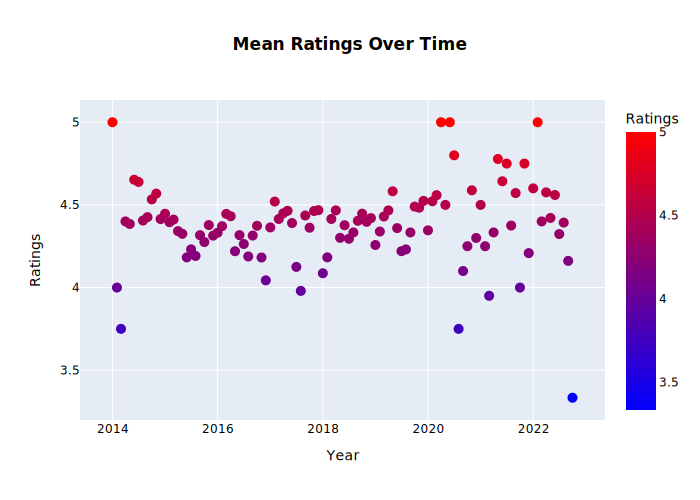

In [7]:
fig = df.groupby("date_of_stay")["ratings"].mean().reset_index().plot(kind='scatter',x="date_of_stay",y='ratings',color='ratings',
    color_continuous_scale=colors.sequential.Bluered,labels={"ratings":"Ratings","date_of_stay":"Year"},title="<b>Mean Ratings Over Time</b>")
fig.update_traces(marker=dict(size=10)) 
fig.update_layout(title_x = 0.5, font={'color':'black'})
fig.show() # A plot of the average rating granted to the hotel is generated - the ratins are fairly consistent though 
# they do appear to be more scattered in recent years - possibly due to fewer people leaving reviews?

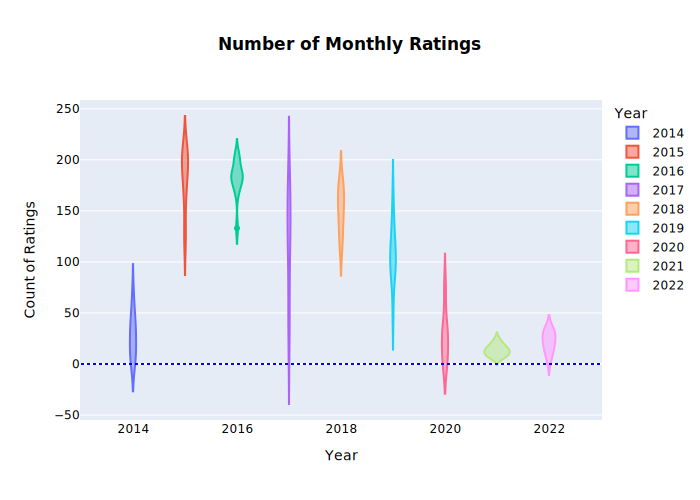

In [8]:
ratings_count = df.groupby("date_of_stay")["ratings"].count().reset_index()
ratings_count["year_of_stay"] = ratings_count["date_of_stay"].dt.year
fig = px.violin(ratings_count, x='year_of_stay', y='ratings',color='year_of_stay', labels={"ratings":"Count of Ratings","year_of_stay":"Year"},
        title="<b>Number of Monthly Ratings</b>")
fig.add_shape(type="line",x0=2013, x1=2023,y0=0, y1=0,line=dict(color="blue", dash="dot"))
fig.update_layout(title_x = 0.5, font={'color':'black'})
fig.show()

# Indeed, a violin plot showing the distribution of the number of ratings per month in a year does show a trend of the number of ratings dying 
# down in more recent years - possibly due to most ratings already having captured the rough sentiment of the place/ the novelty factor
# wearing off/ the inability to scrape the relevant data. The blue dotted line has been placed to indicate the minimum possible number
# of ratings that can be given in one month

In [9]:
bad_rating_upper_lim = 3

# Given the prestige of the hotel, I have considered a rating at/ below 3 to be indicative of some problem 
# within the hotel that ought to be rectified. This can be lowered (or even increased) as one deems it to identify
# negative / positive sentiments in the text - yet as the aim is to pinpoint problems guests have faced - I shall
# be using a rating less than / equal to 3 as a 'poor rating'

poor_ratings = df[df["ratings"]<=bad_rating_upper_lim]
poor_ratings.head()

,user_id,contributions,date_of_stay,ratings,title,content
5,5,53,2022-10-01,2,The pool is nice but hotel room and service is...,"You can go there for casino and infinity pool,..."
8,8,1,2022-09-01,1,Debit card charged without refund after check ...,Stay from 05 sep to 08 sep 2022. Hotel request...
12,12,1,2022-10-01,3,A Hotel that is heaven for Adults but not grea...,We arrived in Singapore as a family. Beforehan...
18,16,26,2018-06-01,3,Overpriced,This is an impressive hotel to look at. The ro...
22,18,21,2022-09-01,3,Disneyland on heat !,If you are looking for luxurious personal serv...


In [10]:
nlp = spacy.load("en_core_web_md") 

In [11]:
def text_preprocessing(sentence):
    sentence = sentence.strip()
    doc = nlp(sentence.lower()) 
    processed_res = " ".join([token.lemma_ for token in doc if not token.is_punct and len(token.lemma_)>2])
    # When processing the text, stopwords are not removed as most 'poor' reviews 
    # were nuanced and also highlighted the pros of the hotel - conjunctions (which are also stopwords)
    # such as 'but' and 'yet' were therefore kept in order to capture the meaning of the review well
    return processed_res 

In [12]:
poor_ratings["tokenised_title"] = poor_ratings["title"].apply(text_preprocessing)

# The title of the review is used as opposed to the content given due to the natural manner in which titles
# by definition aim to capture the overall sentiment of the problems faced by guests in a concise manner - thus requiring 
# comparatively less preprocessing than content

In [13]:
umap_model = UMAP(random_state=r_state) # The UMAP model is a dimensionality reduction technique 
# utilised in the Topic Modelling algorithm BERTopic (which I use in the code further down below)
# to get the optimal number of topics that I aim to represent. Hence, setting it's random state now
# helps to ensure the reproducibility of results by my code fairly. 

In [14]:
sample_content = poor_ratings["tokenised_title"].values

In [15]:
topic_model = BERTopic(min_topic_size=20,umap_model=umap_model) 
topics,probs = topic_model.fit_transform(sample_content)
topic_info = topic_model.get_topic_info()

100%|██████████| 5/5 [00:00<00:00, 171.05it/s]


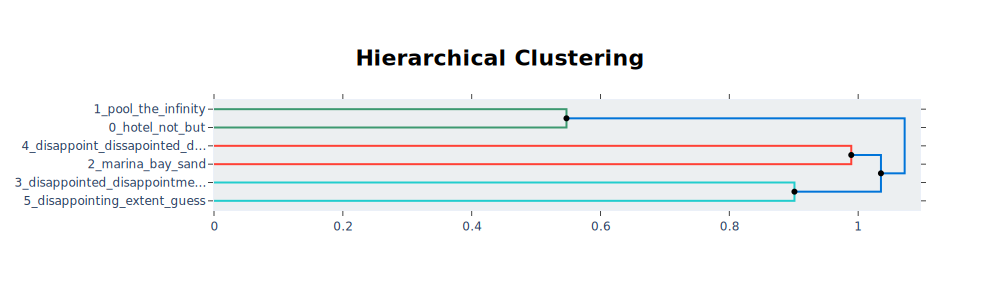

In [16]:
hierarchical_topics = topic_model.hierarchical_topics(sample_content)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

# We can see that a hierarchical tree is formed which is conveniently colour coded to show links between related topics fairly well!
# Nonetheless - we still do see conjunctions such as 'but' pop up in the tree - implying that we do not necessarily have just the problems
# faced by guests displayed below and some of the text could be related to things thought positively by them. This can be rectified through
# the methods employed below. 

In [17]:
nlp.add_pipe("spacytextblob")

In [18]:
doc = nlp(poor_ratings['title'].values[0])
print(doc) # My initial hope was to see if spacy was able to dynamically identify the sentiments of sequences of words and pinpoint areas
# that had a shift in sentiment (polarity) to the negative side by once again looking at conjunctions like 'but'. However, this appears
# to not have worked as well as I hoped as can be seen in the example below - where the sentiment is deemened to be quite good 
# even though the underlying meaning behind the text is poor.
print(doc._.blob.polarity)
print(doc._.blob.sentiment_assessments.assessments)

The pool is nice but hotel room and service is not that good as 5 stars hotel
0.6499999999999999
[(['nice'], 0.6, 1.0, None), (['good'], 0.7, 0.6000000000000001, None)]


In [19]:
poor_ratings.sample(5,random_state=r_state)

,user_id,contributions,date_of_stay,ratings,title,content,tokenised_title
3896,3587,21,2018-03-01,3,"Some Very Good Things, But................","We have been here for a few days now, and leav...",some very good thing but
5315,4958,13,2016-05-01,1,worse and inconvenience for me during my stay,It was indeed worse and inconvenience for me d...,bad and inconvenience for during stay
7828,7408,95,2016-02-01,2,Do your homework on this hotel,We visited this hotel on two occasions ( to ga...,your homework this hotel
8401,7969,72,2015-11-01,1,Only Stayed For The Pool - Wouldn't Again,We checked in about 7pm after a wonderful stay...,only stay for the pool would not again
9959,9510,13,2015-03-01,3,It Doesn't Worth It,In order to celebrate the last day of Chinese ...,not worth


In [20]:
analyzer = SentimentIntensityAnalyzer()

In [21]:
def dynamic_sentiment_analysis(sentence,filter=None):
    doc = nlp(sentence)
    
    clauses = []
    temp_clause = []
    for token in doc:
        temp_clause.append(token.text)
        if token.dep_ in ["cc","mark"]: # to fix this, I decided to segregate the text into different segments before hand as shown here
            clauses.append(" ".join(temp_clause).strip())
            temp_clause = []

    clauses.append(" ".join(temp_clause).strip())
    
    clause_sentiments = {}
    for clause in clauses:
        sentiment = analyzer.polarity_scores(clause) # As well as utilise the VADER sentiment analysis model, which 
        # is more tuned to data that can be found online such as reviews/ comments on a whole host of online platforms
        sentiment_label = (
            "POSITIVE" if sentiment['compound'] > 0.1 
            else "NEGATIVE" if sentiment['compound'] < -0.1 
            else "NEUTRAL"
        )
        clause_sentiments[clause] = {
            "sentiment": sentiment_label, # the resulting segments of text are then labelled as positive/ negative based on the above 
            # criterion (which can be amended as need be) and returned further below
            "compound": sentiment['compound']
        }
    
    if filter==None:
        return clause_sentiments
    else:
        res_sentiments = {}
        for k,v in clause_sentiments.items():
            if v["sentiment"]==filter.upper():
                res_sentiments[k] = v 
        return res_sentiments

In [22]:
sentence = str(doc) # Based on the example given in the code cell 18
results = dynamic_sentiment_analysis(sentence,"NEGATIVE") 
list(results.keys()) # This is more like it ;}

['service is not that good as 5 stars hotel']

In [23]:
poor_ratings["negative_comments"] = poor_ratings["title"].apply(lambda x:" ".join(list(dynamic_sentiment_analysis(x,"NEGATIVE").keys())))

In [24]:
negative_commt = poor_ratings[poor_ratings["negative_comments"].apply(lambda x:len(x)>0)]
# A new column is thus created trained solely off of this more finely tuned data

In [25]:
sample_content_2 = negative_commt["negative_comments"].values

topic_model = BERTopic(min_topic_size=15,umap_model=umap_model) 
topics,probs = topic_model.fit_transform(sample_content_2)
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,124,-1_stay_impersonal_disappointing_trap,"[stay, impersonal, disappointing, trap, touris...","[DISAPPOINTING STAY, Disappointing stay, Poor ..."
1,0,85,0_hotel_worst_in_the,"[hotel, worst, in, the, you, this, at, of, no,...","[WORST HOTEL EVER, Worst hotel experience, Wor..."
2,1,71,1_worth_not_money_the,"[worth, not, money, the, price, it, value, was...","[Not worth the money ...., not worth the money..."
3,2,58,2_good_not_as_bad,"[good, not, as, bad, chaotic, impressed, great...","[Not as good as, not as good as, Not good as]"
4,3,56,3_disappointed_disappointment_more_flawed,"[disappointed, disappointment, more, flawed, b...","[Disappointed, Disappointed, Disappointed]"
5,4,32,4_poor_service_services_property,"[poor, service, services, property, lack, qual...","[Poor service, poor service, Poor service]"
6,5,31,5_service_terrible_customer_appalling,"[service, terrible, customer, appalling, bad, ...","[Terrible service and, terrible customer servi..."
7,6,27,6_disappointing_moments_frustrating_humiliating,"[disappointing, moments, frustrating, humiliat...","[Disappointing, Disappointing, Disappointing]"
8,7,22,7_pool_infinity_the_access,"[pool, infinity, the, access, stunning, could,...","[Infinity pool to die for, Other than the infi..."
9,8,21,8_experience_such_ever_worst,"[experience, such, ever, worst, horrible, very...","[Poor experience, Terrible Experience, Terribl..."


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 116.13it/s]


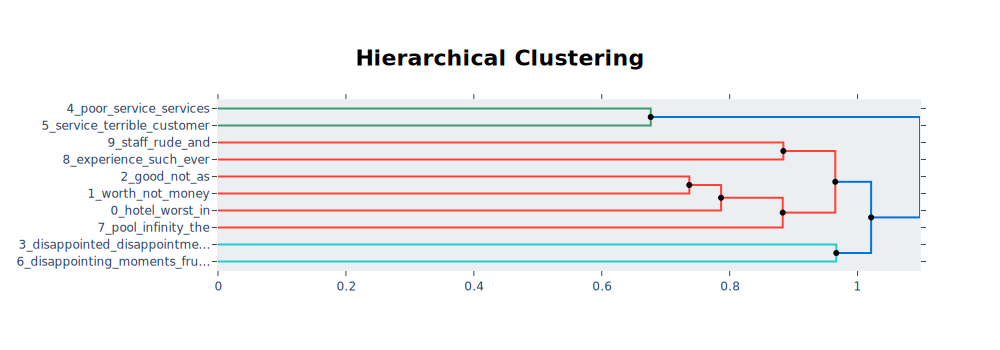

In [26]:
hierarchical_topics = topic_model.hierarchical_topics(sample_content_2)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics) # And the clusters do seem to be much more insightful

# There is however a problem - not all of the titles have yielded clear 'negative comments' for the model to be trained on -
# likely due to some of them being really short and not containing sufficient information on their own to be deemed to be 
# a 'bad review'. This means that the tree below - while very concise - isn't fully representative. To handle that, there's 
# approach number 3

In [27]:
bad_parts = []

for i, r in poor_ratings.iterrows():
    bad_comment = r["negative_comments"]
    if len(bad_comment)>0: # if the data has been processed and segmented - that segment is used
        bad_parts.append(bad_comment)
    else:
        bad_parts.append(r["title"].lower()) # if not - the lowercased title is used instead
# The whole title is used instead of the tokenised bits since BERTopic can work off of complete strings - oftentimes to better results
# due to its ability to capture semantic information very well. Indeed - this is why I selected it instead of other Topic Modelling 
# algorithms like Latent Dirichlet Allocation. 

In [28]:
sample_content_3 = list(map(lambda x:x.replace("â\x80\x99", "'"),bad_parts))
poor_ratings["bad_parts"] = sample_content_3

In [29]:
topic_model = BERTopic(umap_model=umap_model) 
topics,probs = topic_model.fit_transform(sample_content_3)
topic_model.reduce_topics(sample_content_3, nr_topics=14)
reduced_topics = topic_model.topics_
topic_info = topic_model.get_topic_info()

100%|██████████| 12/12 [00:00<00:00, 175.27it/s]


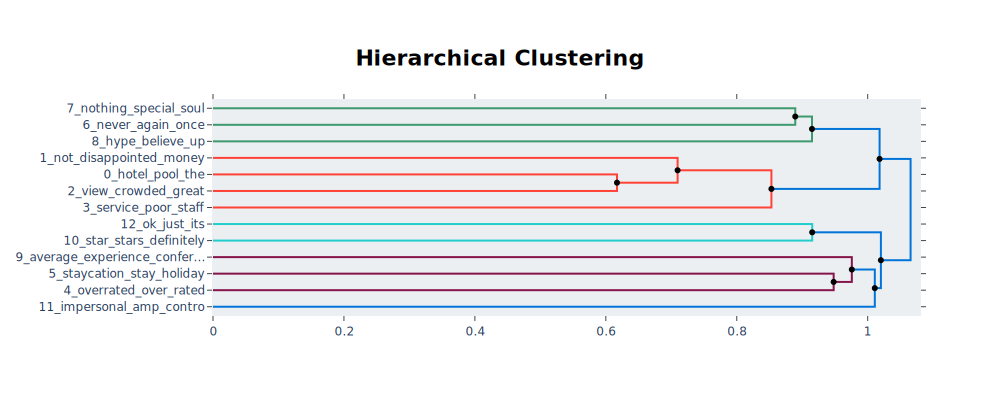

In [30]:
hierarchical_topics = topic_model.hierarchical_topics(sample_content_3)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

# Now this is Clustered Data - Generally into complaints about Service, The hotel being Overrated and Not having much to do
# These clusterings are then mapped much more clearly using the code below

In [31]:
lower_bound, upper_bound = 0.85, 1.1
main_topics = hierarchical_topics[(hierarchical_topics["Distance"]>lower_bound) \
& (hierarchical_topics["Distance"]<upper_bound)].sort_values("Distance",ascending=False).drop_duplicates("Parent_Name")

In [32]:
parent_ids = [23,15,17]
parent_ids = sorted(parent_ids)
org = main_topics[main_topics["Parent_ID"].apply(int).isin(parent_ids)].sort_values("Parent_ID")
org

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
2,15,hotel_pool_the_service_not,"[0, 1, 2, 3]",14,hotel_pool_the_not_but,3,service_poor_staff_customer_and,0.852953
4,17,hype_never_again_nothing_once,"[6, 7, 8]",16,never_again_once_nothing_night,8,hype_believe_up_the_hyped,0.914929
10,23,overrated_stay_over_rated_staycation,"[4, 5, 9, 10, 11, 12]",18,ok_star_stars_not_definitely,21,overrated_over_stay_rated_staycation,1.020169


In [33]:
names = ["Poor-Service","Not-Special","Overrated"] # These names have had to be manually created

In [34]:
mappings = {}
for i,n in enumerate(names):
    mappings[tuple(org["Topics"].values[i])] = n

mappings # Yet the mappings can be fairly easily automated

{(0, 1, 2, 3): 'Poor-Service',
 (6, 7, 8): 'Not-Special',
 (4, 5, 9, 10, 11, 12): 'Overrated'}

In [35]:
mapped_topics = []
for t in reduced_topics:
    for k in mappings:
        if t in k:
            mapped_topics.append(mappings[k])
            break
    else:
        mapped_topics.append('Other')

In [36]:
poor_ratings["main_complaint"] = mapped_topics

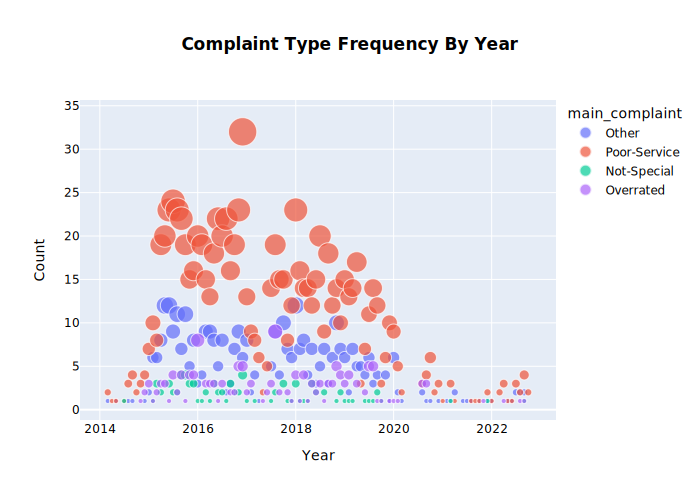

In [37]:
ratings_plot = poor_ratings.groupby(["date_of_stay","main_complaint"])["ratings"].count().reset_index()
px.scatter(ratings_plot,x='date_of_stay', y='ratings', color='main_complaint',size='ratings',
    labels={"date_of_stay":"Year","ratings":"Count"},title="<b>Complaint Type Frequency By Year</b>").update_layout(
    title_x = 0.5, font={'color':'black'})

# We can see that the type of complaints that are frequently granted year after year appear to relate to poor service
# This does have varying interpretations to be fair - yet we can make the assessment that guests do expect better service 
# in varying areas given the luxury of the hotel they are staying in. The complaints do die down as the years go by - yet 
# as previously noticed - so too do the number of reviews. A more accurate measure would therefore be looking at the proportion of 
# reviews left by guests which are negative

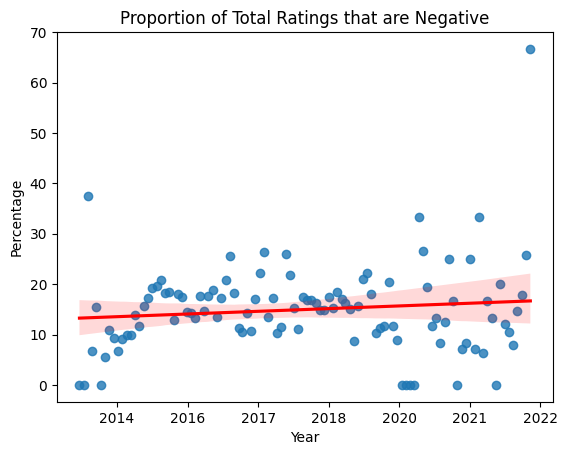

In [38]:
poor_rating_perc = ((poor_ratings.groupby("date_of_stay")["ratings"].count() \
    / df.groupby("date_of_stay")["ratings"].count()).fillna(0))
sns.regplot(x=poor_rating_perc.index.map(pd.Timestamp.toordinal),y=poor_rating_perc.values*100,data = poor_rating_perc, 
    line_kws={'color':'red'})
labels = list(map(lambda x: datetime.fromordinal(int(x)).strftime("%Y"),plt.xticks()[0][1:-1]))
plt.xticks(plt.xticks()[0][1:-1],labels = labels)
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.title("Proportion of Total Ratings that are Negative")
plt.show()

# For the most part - it does seem that the proportion of negative reviews is fairly constant with a weak inclining trend behind it

# <Seaborn was selected instead of plotly in this instance due to the comparatively easier nature of implementing a confidence-interval
# in sebaorn than plotly>

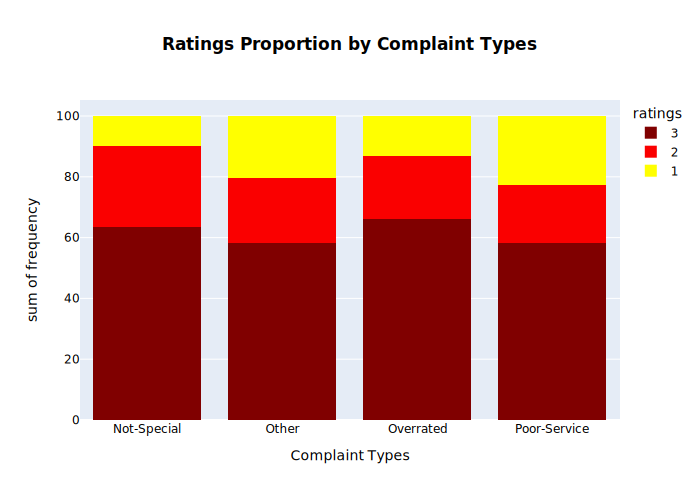

In [39]:
rating_proportion = (poor_ratings.groupby("main_complaint")["ratings"].value_counts(normalize=True)*100).reset_index()
px.histogram(rating_proportion,x='main_complaint',y='proportion',color='ratings',barmode='stack',
    color_discrete_sequence=colors.sequential.Jet[::-1],labels={"main_complaint":"Complaint Types","proportion":"frequency"},
    title = "<b>Ratings Proportion by Complaint Types</b>").update_layout(title_x = 0.5, font={'color':'black'})

# Furthermore - we can see that Reviews related to 'poor service' and 'other' factors are likely to have the highest proportion of 
# 1 Stars among them. This - combined with the fact that the number of poor ratings have been gradually increasing in proportion 
# and that Poor Service is one of (really the most) common complaints guests have leads to the expected outcome we see below

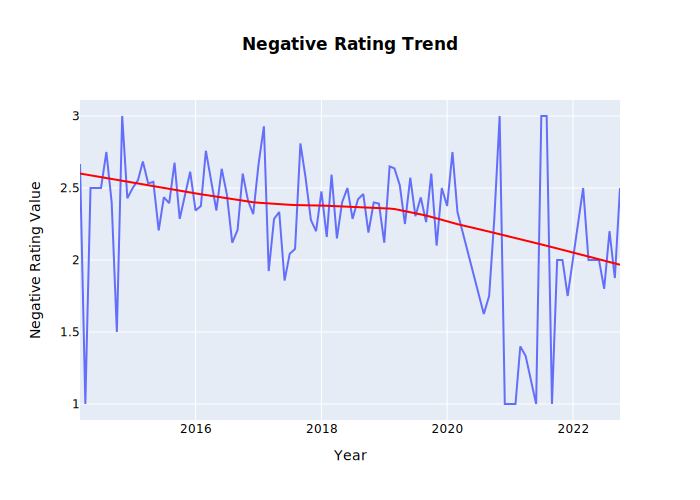

In [40]:
fig = poor_ratings.groupby("date_of_stay")["ratings"].mean().reset_index().plot(kind='scatter',x="date_of_stay",y='ratings',trendline='lowess',
    trendline_color_override='red',title="<b>Negative Rating Trend</b>",labels={"date_of_stay":"Year","ratings":"Negative Rating Value"})
fig.update_traces(mode = 'lines')
fig.update_layout(title_x = 0.5, font={'color':'black'})
fig.show()

# That of the average Value of the negative rating plummeting from ard 2.6 in 2014 to 2 at the end of 2022
# Truly this highlights the pertinent need to address the issue of poor-service by the hotel management in order, if not to attract
# more guests - to at least improve the reputation of the hotel and maintain a solid base of tourists to return for longer.

## Conclusion

The aim of the project has been to essentially convey a story backed by data in an aesthetically pleasing and comprehensive manner - on which I find is especially important in the working world to influence the policies implemented by those who hold power. While this case study has been about a relatively straightforward issue - it does have applicability in many fields; and indeed room to improve in - with the possibility of dynamic sentiment analysers being implemented by companies to understand their consumers better. Or indeed incorporating interactive visualisations to gather crucial data-based information to form judgements quickly. Truly, Exploratory Data Analysis and Visualisations is a key part of decision making and judgement calling - and it definitely helps to be aesthetic too :)